<a href="https://colab.research.google.com/github/bogdan-p-s/educational_projects/blob/master/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7_%D0%B2%D1%8B%D1%80%D1%83%D1%87%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt

import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error

seed = 42

### Загрузка данных в один датасет и предобработка:

In [2]:
files = glob.glob('/content/drive/MyDrive/Colab Notebooks/Тестовые/Сбер/*.xlsx')

df2 = pd.DataFrame()
for path in files:
  df = pd.read_excel(path, usecols ='i:ay')

  df.columns = df.loc[27]
  df = df.loc[[28, 42]]
  df = df.T
  df.columns = df.iloc[0]
  df = df.iloc[1:]

  df = df.reset_index()
  df['Revenue'] = df['Revenue'].astype('float')
  df['Operating Income'] = df['Operating Income'].astype('float')
  #df['month'] = df[27].values.astype('datetime64[M]')
  # df = df[['month', 'Revenue', 'Operating Income']]

  df.columns = ['month', 'revenue', 'op_income']
  df.index.name = ''
  df['company'] = path[53:(len(path)-5)]

  df2 = df2.append(df)

In [3]:
df2.index = [i for i in range(0, len(df2))]

df2['year'] = df2.month.dt.year
df2['month_n'] = df2.month.dt.month

Взглянем на динамику медианных значений:

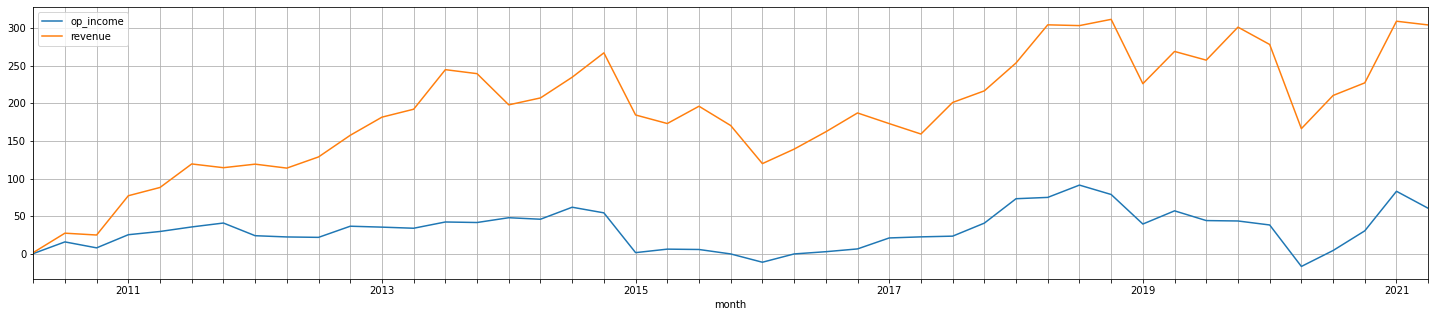

In [108]:
df2.pivot_table(index='month', values=['revenue',	'op_income'], aggfunc='median').plot(figsize=(25, 5))
plt.xticks(df2.pivot_table(index='month', values=['revenue',	'op_income'], aggfunc='median').index)
plt.grid()

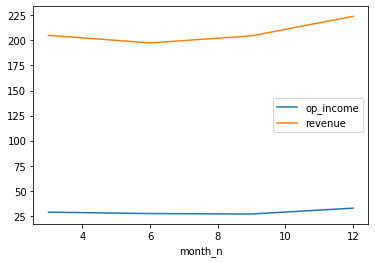

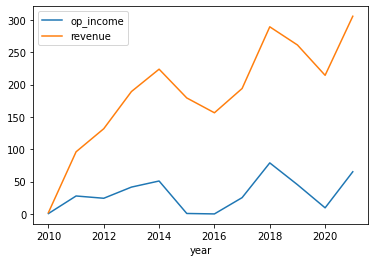

In [109]:
df2.pivot_table(index='month_n', values=['revenue',	'op_income'], aggfunc='median').plot()
df2.pivot_table(index='year', values=['revenue',	'op_income'], aggfunc='median').plot()

- ярковыраженной внутригодовой сезонности не наблюдается, кроме повышения медианного дохода в конце года
- виден восходящий тренд на протяжении всего периода, за исключением проседания рынка в 1 квартале 2016 и локдауна в 2020

 **Необходима "разметка" таких аномалий**

 **(!) Ввиду сильной корреляции для каждой компании по отдельности revenue и op_income и с целью упрощения задачи, прогноз будет осуществляться только по revenue**

 Взглянем на количество кварталов с нулевыми значениями в разрезе компаний (далее такие значения мы будем отсекать):

In [ ]:
df2[df2.revenue==0].pivot_table(index='company', values='revenue', aggfunc='count')

,revenue
company,
AMPY,3
AR,3
BRY,27
BSM,15
CDEV,20
CRC,14
FANG,2
LONE,20
LPI,2


### Прогноз с окном пропуска в 3 предыдущих пункта (т. к. прогнозируем на 4 пункта)
upd: ввиду того, что большое количество записей выпадает, это становится критичным для молодых компаний, с малым количеством записей. Лучше использовать прогноз другим способом, без такого окна, например с итеративным предсказанием по 1 строке и добалением ее "как факт" для следующей


**Метрика - МАРЕ** - т к нам важнее давать правильные рузльтат по поценке каждой компании раздельно (в процентном отношении), и МАРЕ для этого хорошо подходит

In [122]:
def split(data, target, month_pred):
  if target == 'revenue':
    data = data.drop('op_income', axis=1)
  else:
    data = data.drop('revenue', axis=1)

  # X = data.drop(target, axis=1)
  # Y = data[target]
  # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.13, shuffle=False, random_state=123455)

  train = data[data.month <= '2019-09-30']
  test = data[data.month >= month_pred]

  X_train, Y_train = train.drop(target, axis=1), train[target]
  X_test, Y_test = test.drop(target, axis=1), test[target]

  return X_train, X_test, Y_train, Y_test

def mape(y_true, y_pred): 
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return (np.mean(np.abs((y_pred - y_true) / y_true)) * 100).round(2)

def make_lag_and_roll(df, lag, roll):
  if len(df[df.revenue!=0]) <= 10:
    return df
  
  if 10 < len(df[df.revenue!=0]) <= 17:
    lag = 2
    roll = 2
    print('<17')
  
  for lag in range(1, lag + 1):
    df['lag_{}'.format(lag)] = df['revenue'].shift(lag+3)

  df['rolling_mean'] = df['revenue'].shift(3).rolling(roll).mean()
  return df

In [144]:
target = 'revenue'

comp = []
mape_all = []
mae_all = []
for i in df2.company.unique():
  df = df2[(df2.company==i)&(df2.revenue!=0)].copy()
  
  df = make_lag_and_roll(df, 2, 3)

  df_ = df.drop(['year', 'company'], axis=1).dropna()

  # кодирование
  df_['month_n'] = df_['month_n'].astype('object')
  df_ohe = pd.get_dummies(df_, drop_first=True)

  # деление на выборки
  df_ = df_ohe.dropna()
  X_train, X_test, Y_train, Y_test = split(df_, target, '2020-09-30')

  # нормирование
  scaler = StandardScaler()
  scaler.fit(X_train.drop('month', axis=1))
  X_train = scaler.transform(X_train.drop('month', axis=1))
  X_test = scaler.transform(X_test.drop('month', axis=1))

  model = RandomForestRegressor(random_state=seed)
  model.fit(X_train, Y_train)
  pred = model.predict(X_test)

  comp.append(i)
  mape_all.append(mape(Y_test, pred))
  mae_all.append(mean_absolute_error(Y_test, pred))
  
  #print(mape(Y_test, pred))

<17
<17


Остановился на случайном дереве, т к оно показало лучший результат по сравнению с лог регрессией, возможно, ввиду сильных отклнений в данных. Для бустингов, при раздельном предсказании по каждой компании, данных маловато, однако не "углублялся"

In [145]:
result = pd.DataFrame({'company': comp, 'MAPE': mape_all, 'MAE': mae_all} )
result.sort_values('MAPE', ascending=False).head(10)

,company,MAPE,MAE
49,NOG,446.89,125.849420
0,CHK,145.80,1352.400020
11,BSM,137.47,80.649016
34,SD,129.75,40.375495
41,DVN,90.94,1217.550040
8,WLL,87.09,186.481533
28,CRK,74.31,216.891995
14,BATL,69.38,33.245470
18,GDP,63.28,19.187897
17,BCEI,63.01,53.079716


**Результат:**

In [146]:
print('mean MAPE: {:.2f}'.format(result.MAPE.mean()), '   median MAPE: {:.2f}'.format(result.MAPE.median()))
print('mean MAE:  {:.2f}'.format(result.MAE.mean()), '  median MAE:  {:.2f}'.format(result.MAE.median()))

mean MAPE: 51.20    median MAPE: 36.81
mean MAE:  222.59   median MAE:  88.69


Рассмотрим динамику трех худших компаний по МАРЕ:

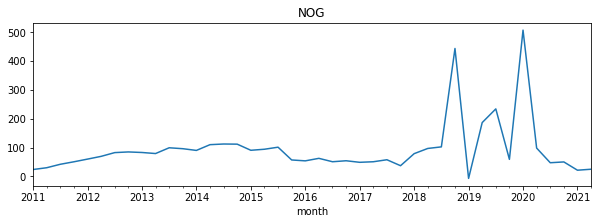

Стандартное откл.: 96.2 среднее: 93.4


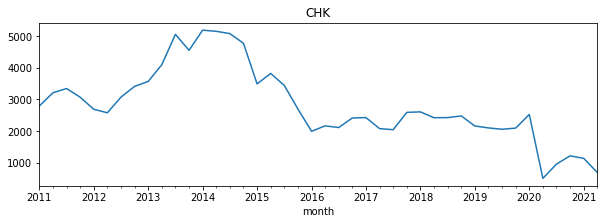

Стандартное откл.: 1184.2 среднее: 2817.6


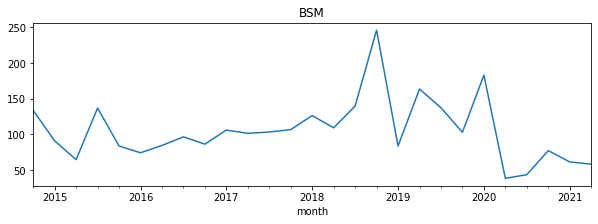

Стандартное откл.: 44.5 среднее: 105.3


In [147]:
df2_ = df2.set_index('month')
for i in result.sort_values('MAPE', ascending=False)['company'].head(3):
  df2_[(df2_.company==i)&(df2_.revenue!=0)]['revenue'].plot(figsize=(10, 3));
  plt.title(i)
  plt.show()
  print('Стандартное откл.: {:.1f}'.format(df2_[(df2_.company==i)&(df2_.revenue!=0)]['revenue'].std()), 'среднее: {:.1f}'.format(df2_[(df2_.company==i)&(df2_.revenue!=0)]['revenue'].mean()))

- NOG - в глаза бросается явные всплекски выручки в конце 2018 и начале 2020 года (при относительно стационарных результатах с 2011 г), что сильно сказалось на прогнозе
- CHK и  BSM - почти весь период, который попал в прогнозный интервал, существенно ниже фактов компании за все предыдущее время, начался он с локдауна в 2020, такое отклонение было довольно существенно "поймать" без учета дополнительных данных

Необходимо детальнее проработать все причины.

### Что можно было бы сделать еще:
- в качестве эксперимента - предсказание на всех компаниях (вместе) ИЛИ кластеризация и предсказание по компаниям внутри кластера с выявлением коэффициентов сезонности и пр., для выявлени общих закономерностей
- использование "внешних" данных, в том числе и для объяснения аномальных значений, обработка этих аномалий (при необходимости)
- проработка дополнительных признаков ( в т ч с точки зрения временных рядов, ...)
- итеративный прогноз по одному кварталу (а не сразу на год, как сейчас) с добавлением его в датасет для лагов следующей строки. Это позволило бы не делать окно "пропуска" в 3 месяца и опираться на более свежие данные
- подбор гиперпараметров и параметров временных рядов - количетсво лагов, ширины скользящего среднего (или его вариации, например, взвешенное скользящее) и др. (например, для молодых компаний эти значения  должны быть меньше, чтобы не "съедать" данные первых периодов при отсечении образующихся пропусков (частично реализовал), а у более старых компаний эти значения могут быть больше) и тестирование других моделей
- кросс-валидация данных при разработке пайплайна (в данный момент тестовая выборка просто отсекается по конкретной дате)



In [ ]:
###  Подбор шага

# ###  Подбор шага
# lag_all = []
# rolling_all = []
# rmse_all = []
# for max_lag in range(1, 8+1, 1):
#     for rolling_mean_size in range (1, 8+1, 1):
#         df_ = df.copy()
#         df_['rolling_mean'] = df_['num_orders'].shift().rolling(rolling_mean_size).mean()
        
#         for lag in range(1, max_lag + 1):
#             df_['lag_{}'.format(lag)] = df_['num_orders'].shift(lag+3)
        
#         df_ = df_.dropna()
#         X_train, X_test, Y_train, Y_test = split(df_)
        
#         model = LinearRegression()
#         model.fit(X_train, Y_train)
#         pred = model.predict(X_test)
        
#         lag_all.append(max_lag)
#         rolling_all.append(rolling_mean_size)
#         rmse_all.append(rmse(Y_test, pred))

# result = pd.DataFrame({'lag': lag_all, 'rolling': rolling_all, 'RMSE': rmse_all} )
# result.sort_values('RMSE').head(10)

### Попытки кластеризации

# df3 = df2.pivot_table(index='company',values='revenue', columns='month')#.plot(figsize=(25, 15))
# df3 = df3.iloc[:, 3:].fillna(0).copy()
# df3.columns =  [i for i in range (0, len(df3.columns))] #rename for clustering

# df3 = df3.iloc[:, 3:].fillna(0).copy()
# df3.columns =  [i for i in range (0, len(df3.columns))] #rename for clustering

# df_4_cluster = df3.copy()

# #categoricals = dfs.categoricals.tolist()

# #df_4_cluster = pd.get_dummies(df_4_cluster, columns=categoricals, drop_first=False)

# #df_4_cluster.drop('month', axis=1, inplace=True)

# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df_4_cluster)
# df_scaled = pd.DataFrame(df_scaled, columns=df_4_cluster.columns)

# pca = PCA(n_components=0.95, svd_solver='full', random_state=seed)
# pca.fit(df_scaled)
# df_pca = pca.transform(df_scaled)

# kmeans = KMeans(n_clusters=7, random_state=seed).fit(df_pca)

# df3['cluster'] = kmeans.labels_